### Info
Plotting comparisons

In [1]:
import numpy as np
import pandas as pd

### Load data into a DataFrame

In [2]:
min_ind = 1
max_ind = 1

model_names = ('hls','qkeras','qonnx_init','qonnx_mod')
pred_all = []   # will be a list of arrays from each model

for model_name in model_names:
    pred_single = np.array([])
    for file_index in range(min_ind, max_ind+1):
        data = np.load('./pred_Test_corr/preds_'+model_name+str(file_index)+'.npy')
        pred_single = np.append(pred_single,data)
        #print(pred_single.shape)
    pred_all.append(pred_single)

pred_all = np.array(pred_all).T

In [3]:
pred_all.shape

(2048, 4)

In [4]:
df = pd.DataFrame(pred_all, columns=model_names)
df

,hls,qkeras,qonnx_init,qonnx_mod
0,2.375,2.750,2.750,2.750
1,0.625,0.875,0.875,0.875
2,1.500,1.750,1.750,1.750
3,0.750,1.000,1.000,1.000
4,29.500,28.875,28.875,28.875
...,...,...,...,...
2043,10.750,11.000,11.000,11.000
2044,0.625,0.750,0.750,0.750
2045,1.375,1.500,1.500,1.500
2046,1.250,1.500,1.500,1.500


### Compare predictions

In [5]:
df['qxinit_qkeras'] = df['qonnx_init'] - df['qkeras']
df['qxinit_qkeras'].value_counts()

qxinit_qkeras
0.0    2048
Name: count, dtype: int64

modified vs unmodified qonnx with respect to hls

In [6]:
df['qxinit_hls'] = df['qonnx_init'] - df['hls']
df['qxmod_hls'] = df['qonnx_mod'] - df['hls']

print(df['qxinit_hls'].value_counts())
print(df['qxmod_hls'].value_counts())

qxinit_hls
 0.125    772
 0.250    726
 0.000    259
 0.375    196
-0.125     48
 0.500     24
-0.250     16
-0.375      2
-0.750      2
-0.625      1
-1.375      1
-0.500      1
Name: count, dtype: int64
qxmod_hls
 0.250    738
 0.125    545
 0.000    388
 0.375    180
 0.500     80
-0.125     55
-0.250     27
 0.625     15
-0.375     10
-0.500      4
-0.625      3
 0.750      2
-2.000      1
Name: count, dtype: int64


### Create histograms

In [7]:
import matplotlib.pyplot as plt

In [8]:
dfpl = pd.DataFrame([df['qxinit_hls'].value_counts(),df['qxmod_hls'].value_counts()])
dfpl = dfpl.transpose()
dfpl.columns = ['init','mod']
dfpl = dfpl.fillna(0)
dfpl /= dfpl['init'].sum()
dfpl *= 100
dfpl = dfpl.sort_index()
dfpl

,init,mod
-2.000,0.000000,0.048828
-1.375,0.048828,0.000000
-0.750,0.097656,0.000000
-0.625,0.048828,0.146484
-0.500,0.048828,0.195312
-0.375,0.097656,0.488281
-0.250,0.781250,1.318359
-0.125,2.343750,2.685547
0.000,12.646484,18.945312
0.125,37.695312,26.611328


In [9]:
diffs = dfpl.index.to_numpy()[1:]
dfpl.keys()[0]

'init'

<Axes: >

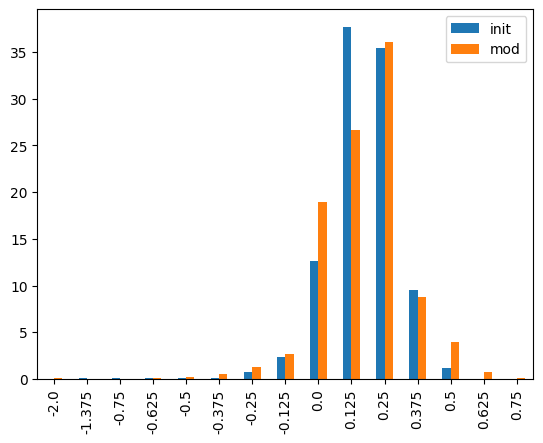

In [15]:
dfpl.plot.bar()

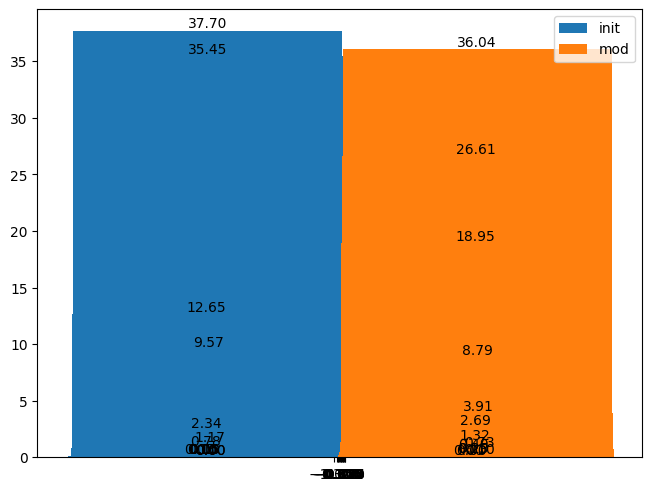

In [10]:
fig, ax = plt.subplots(layout='constrained')
width = 50.

for i in range(len(dfpl.keys())):
    b = ax.bar(diffs+(-1+i)*width, dfpl.values[:,i][1:], width, label=dfpl.keys()[i], align='edge')
    ax.bar_label(b, fmt='{:.2f}')

ax.legend()
ax.set_xticks(diffs)

In [11]:
# Categorize differences (deviations from hls preds)
dfpl['cat'] = dfpl.index.map(lambda x: 
    '0.0' if x==0.0 else(
        '0.125' if x==0.125 else(
            '0.125-250' if x<250.0
            else 'more')
    )
)

catdf = dfpl.groupby('cat').sum()

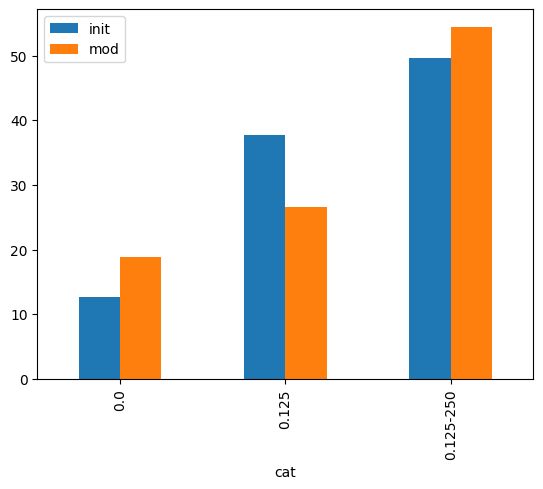

In [12]:
p = catdf.plot.bar()

In [13]:
catdf.values[:,1]

array([18.9453125 , 26.61132812, 54.44335938])

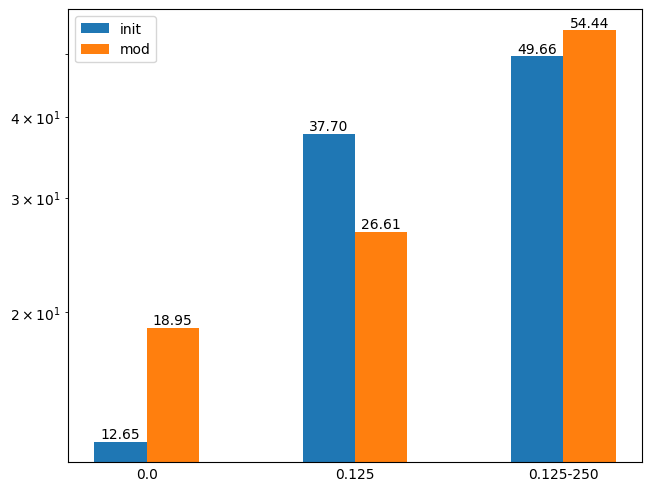

In [14]:
fig, ax = plt.subplots(layout='constrained')
width = 0.25
xticks = np.arange(catdf.shape[0])

for i in range(len(catdf.keys())):
    b = ax.bar(xticks+(-1+i)*width, catdf.values[:,i], width, label=catdf.keys()[i], align='edge')
    ax.bar_label(b, fmt='{:.2f}')

ax.legend()
ax.set_xticks(xticks)
ax.set_xticklabels(catdf.index.to_list())
ax.set_yscale('log')
ax.xaxis.set_tick_params(length=0)